In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# train_data = pd.read_csv('./Train_Test_Splits/Context/train.csv')
# test_data = pd.read_csv('./Train_Test_Splits/Context/test.csv')
# df = pd.concat([train_data, test_data], axis=0)
# df.info()

df = pd.read_csv('./data/merge_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361346 entries, 0 to 361345
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           361346 non-null  int64  
 1   track_id          361346 non-null  object 
 2   hashtag           361346 non-null  object 
 3   created_at        361346 non-null  object 
 4   score             361346 non-null  float64
 5   lang              361346 non-null  object 
 6   tweet_lang        361346 non-null  object 
 7   time_zone         328718 non-null  object 
 8   rating            361346 non-null  int64  
 9   danceability      361346 non-null  float64
 10  energy            361346 non-null  float64
 11  key               361346 non-null  int64  
 12  loudness          361346 non-null  float64
 13  mode              361346 non-null  int64  
 14  speechiness       361346 non-null  float64
 15  acousticness      361346 non-null  float64
 16  instrumentalness  36

In [2]:
(df['score'] == 1).sum(), (df['score'] == 0).sum()
df = df[~df['score'].isin([0, 1])]
(df['score'] == 1).sum(), (df['score'] == 0).sum()

(0, 0)

In [3]:
# 先做缺失值填充
# 一些音乐特性取平均值
lack_columns = ['instrumentalness', 'liveness', 'speechiness', 'danceability', 'valence', 'acousticness', 'energy']
for column in lack_columns:
    df[column] = df[column].fillna(value=df[column].mean())

# 音调和调式、时区可简单取上一条记录的值
df = df.ffill()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303682 entries, 0 to 361345
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           303682 non-null  int64  
 1   track_id          303682 non-null  object 
 2   hashtag           303682 non-null  object 
 3   created_at        303682 non-null  object 
 4   score             303682 non-null  float64
 5   lang              303682 non-null  object 
 6   tweet_lang        303682 non-null  object 
 7   time_zone         303682 non-null  object 
 8   rating            303682 non-null  int64  
 9   danceability      303682 non-null  float64
 10  energy            303682 non-null  float64
 11  key               303682 non-null  int64  
 12  loudness          303682 non-null  float64
 13  mode              303682 non-null  int64  
 14  speechiness       303682 non-null  float64
 15  acousticness      303682 non-null  float64
 16  instrumentalness  30

In [4]:
df.describe()

,user_id,score,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,3.036820e+05,303682.000000,303682.0,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000
mean,7.432104e+08,0.618165,1.0,0.570280,0.623769,5.336612,-8.915302,0.633709,0.100953,0.322850,0.231588,0.210791,0.445987,122.040473
std,6.540217e+08,0.219728,0.0,0.179191,0.266659,3.593820,5.445871,0.481791,0.161074,0.350111,0.357393,0.190825,0.261150,29.593791
min,2.129130e+05,0.050000,1.0,0.000000,0.000756,0.000000,-41.808000,0.000000,0.000000,0.000000,0.000000,0.011200,0.000000,0.000000
25%,2.684025e+08,0.637500,1.0,0.454000,0.430000,2.000000,-11.000000,0.000000,0.036100,0.009550,0.000000,0.096800,0.224000,100.511000
50%,4.937799e+08,0.700000,1.0,0.581000,0.675000,6.000000,-7.564000,1.000000,0.049500,0.157000,0.000462,0.125000,0.423000,122.567000
75%,1.083272e+09,0.766667,1.0,0.708000,0.853000,8.000000,-5.254000,1.000000,0.084000,0.648000,0.514000,0.260000,0.655000,139.288000
max,2.933948e+09,0.971875,1.0,0.981000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,0.995000,0.995000,0.995000,243.372000


In [5]:
# # 去除一些可能的噪音
# df = df[df['tempo'] >= 20]
# df = df[df['tempo'] <= 200]
# df = df[df['energy'] >= 0.2]
# df = df[df['loudness'] >= -20]

# # 4-18添加，去除可能的噪音
# df = df[df['liveness'] <= 0.7]
# df = df[df['speechiness'] <= 0.4]
# df = df[df['acousticness'] <= 0.75]
# print(df.describe())

### 探索性数据分析（EDA）
用训练集df完成一些数据分析
#### 单变量分析
* 时区（Time_zone）
* 语言（Tweet_lang and lang）
* 调式（Mode）
* 音调（Key）
* 推文标签（Hashtag）
* 音乐情绪（Valence）
 
 ......

In [6]:
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小

Amsterdam                     64574
Beijing                       56725
Central Time (US & Canada)    53175
Eastern Time (US & Canada)    34579
Pacific Time (US & Canada)    31220
Quito                         17281
Berlin                        13636
Hong Kong                      4047
Paris                          3900
London                         3445
Athens                         2750
Santiago                       1916
Arizona                        1706
Irkutsk                        1676
Atlantic Time (Canada)         1241
Tokyo                          1128
Dublin                          989
La Paz                          957
Brasilia                        640
Mexico City                     626
Jakarta                         591
Madrid                          553
Moscow                          544
Name: time_zone, dtype: int64


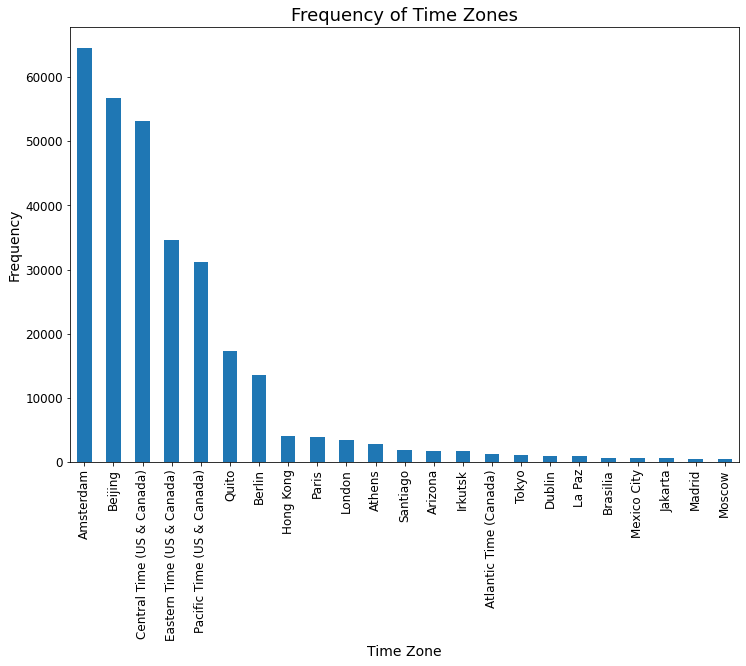

In [7]:
# 时区
time_zone_count = df['time_zone'].value_counts()
time_zone_count = time_zone_count[time_zone_count > 500]
print(time_zone_count)
time_zone_count.plot(kind='bar')
plt.xlabel('Time Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Time Zones')
plt.show()

In [8]:
time_zone_view = time_zone_count[time_zone_count > 10000]
time_zone_view

Amsterdam                     64574
Beijing                       56725
Central Time (US & Canada)    53175
Eastern Time (US & Canada)    34579
Pacific Time (US & Canada)    31220
Quito                         17281
Berlin                        13636
Name: time_zone, dtype: int64

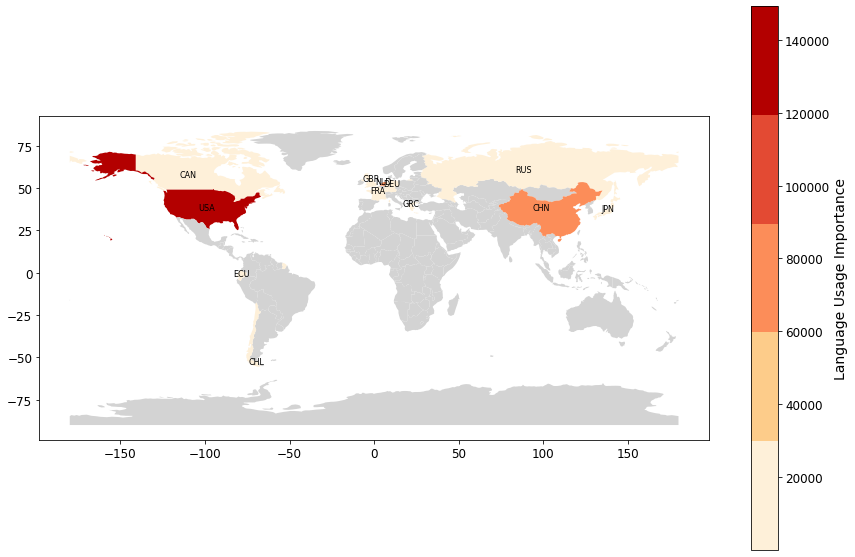

In [9]:
import geopandas as gpd
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

country_importance = {'USA': 77376 + 35099 + 35038 + 1747, 'NLD': 65110, 'CHN': 56730 + 7948, 'ECU': 17876,
                   'GBR': 18546 + 4272, 'DEU':14209, 'FRA':5284, 'GRC':2910, 'CHL':2247, 'CAN':1768, 'RUS':1694, 'JPN':1220 }

# 加载世界地图
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['importance'] = world['iso_a3'].apply(lambda x: country_importance.get(x, 0))


# 定义一个自定义颜色映射
cmap = ListedColormap(['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000'])
# 确保0值以外的数据使用cmap，0值数据使用特定颜色（如灰色）
cmap.set_under('lightgrey')

# 绘制地图，颜色深浅表示重要程度
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='importance', ax=ax, legend=True,
           legend_kwds={'label': "Language Usage Importance"},
           cmap=cmap,
           vmin=0.0001)  # 使用颜色映射，深色表示高重要性

# 标注国家名称
for iso_a3, importance in country_importance.items():
    # 找到对应国家
    country = world[world['iso_a3'] == iso_a3]
    if not country.empty:
        # 计算国家的代表点（几何中心）
        repr_point = country.geometry.representative_point().values[0]
        # 在地图上标注国家ISO代码或名称
        plt.text(s=iso_a3, x=repr_point.x, y=repr_point.y, horizontalalignment='center', fontsize=8)

plt.show()

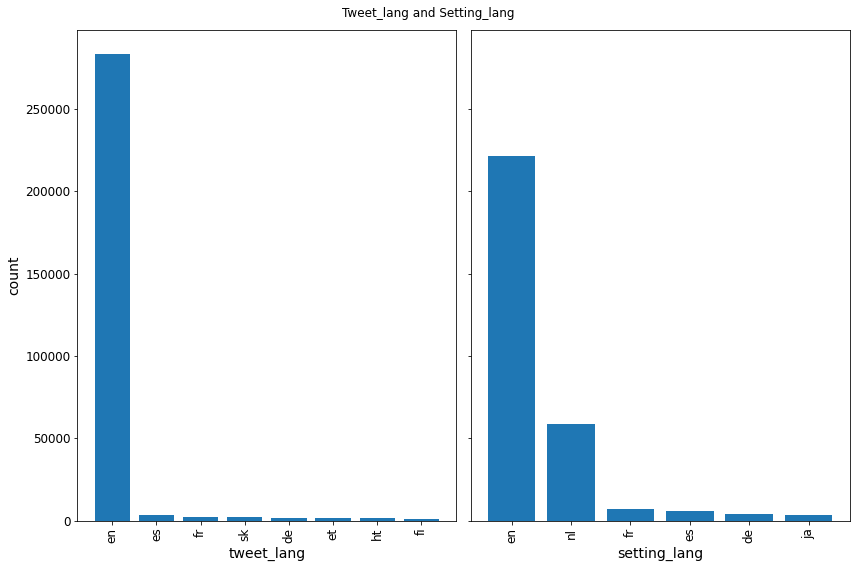

In [10]:
# 推文语言和推特界面语言
fig, axes = plt.subplots(1, 2, figsize=(12,8),sharey=True)
fig.suptitle('Tweet_lang and Setting_lang')
tweet_lang_count = df['tweet_lang'].value_counts()
tweet_lang_count = tweet_lang_count[tweet_lang_count > 1000]
axes[0].bar(tweet_lang_count.index, tweet_lang_count.values)
axes[0].set_xlabel('tweet_lang')
axes[0].set_ylabel('count')
axes[0].tick_params(axis='x', rotation=90)

lang_count = df['lang'].value_counts()
lang_count = lang_count[lang_count > 1000]
axes[1].bar(lang_count.index, lang_count.values)
axes[1].set_xlabel('setting_lang')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

en - 英语 (English), 广泛使用于多个国家和地区。
nl - 荷兰语 (Dutch), 荷兰、比利时部分地区。
fr - 法语 (French), 法国、比利时、瑞士、加拿大部分地区等。
es - 西班牙语 (Spanish), 西班牙、拉丁美洲大部分国家。
de - 德语 (German), 德国、奥地利、瑞士部分地区等。
ja - 日语 (Japanese), 日本。
it - 意大利语 (Italian), 意大利。
pt - 葡萄牙语 (Portuguese), 葡萄牙、巴西。
tr - 土耳其语 (Turkish), 土耳其。
ru - 俄语 (Russian), 俄罗斯。
id - 印度尼西亚语 (Indonesian), 印度尼西亚。
en-gb / en-GB - 英国英语 (British English), 英国。
sv - 瑞典语 (Swedish), 瑞典。
pl - 波兰语 (Polish), 波兰。
no - 挪威语 (Norwegian), 挪威。
fi - 芬兰语 (Finnish), 芬兰。
hu - 匈牙利语 (Hungarian), 匈牙利。
cs - 捷克语 (Czech), 捷克共和国。
ca - 加泰罗尼亚语 (Catalan), 西班牙加泰罗尼亚地区。
eu - 巴斯克语 (Basque), 西班牙和法国的巴斯克地区。
zh-tw - 繁体中文 (Traditional Chinese), 主要在台湾、香港使用。
zh-Hans - 简体中文 (Simplified Chinese), 中国大陆。
ar - 阿拉伯语 (Arabic), 多个阿拉伯国家和地区。
da - 丹麦语 (Danish), 丹麦。
uk - 乌克兰语 (Ukrainian), 乌克兰。
ko - 韩语 (Korean), 韩国。
gl - 加利西亚语 (Galician), 西班牙加利西亚地区。
xx-lc - 不是标准的语言代码，可能是某个特定系统或数据集的特定标识。

**结论1：**
数据集以美国、荷兰、中国用户为主，推文主要使用英语

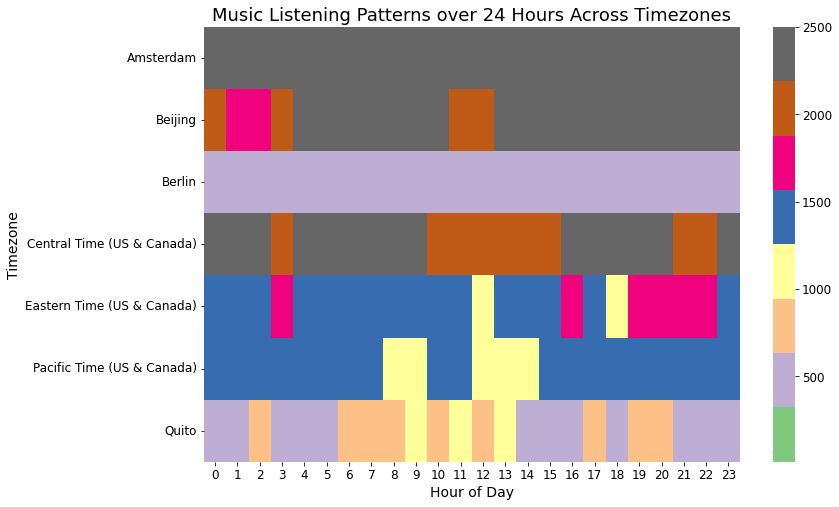

In [11]:
# 热图：几大时区在一天中24小时的听歌分布
import seaborn as sns
import pytz
from datetime import datetime

# 获取小时
df['hours'] = pd.to_datetime(df['created_at']).dt.hour

# 确保hours列涵盖0到23所有小时
hours = np.arange(24)

# 对time_zone和hours进行分组计数，然后重塑数据格式
result = (
    df.groupby(['time_zone', 'hours'])
    .size()
    .unstack(fill_value=0)  # 将hours变成列，缺失值填充0
    .reindex(columns=hours, fill_value=0)  # 确保所有小时都有，缺失的填充0
    .stack()  # 如果需要，可以将数据stack回长格式
    .reset_index(name='count')  # 重置索引，并给计数列命名为'count'
)
result = result[result['time_zone'].isin(time_zone_view.index)]
reshape_result = result.pivot(index='hours', columns='time_zone', values='count')
reshape_result = reshape_result.transpose()

# 绘制热图
sns.heatmap(reshape_result, cmap='Accent', vmin=10, vmax=2500)
plt.title('Music Listening Patterns over 24 Hours Across Timezones')
plt.ylabel('Timezone')
plt.xlabel('Hour of Day')
plt.show()


**结论：** 有些时区一天内听歌分布得较均匀，如Amesterdam、Arizona、Athens等，Beijing在4-11点，13点到24点听歌人都比较多等等

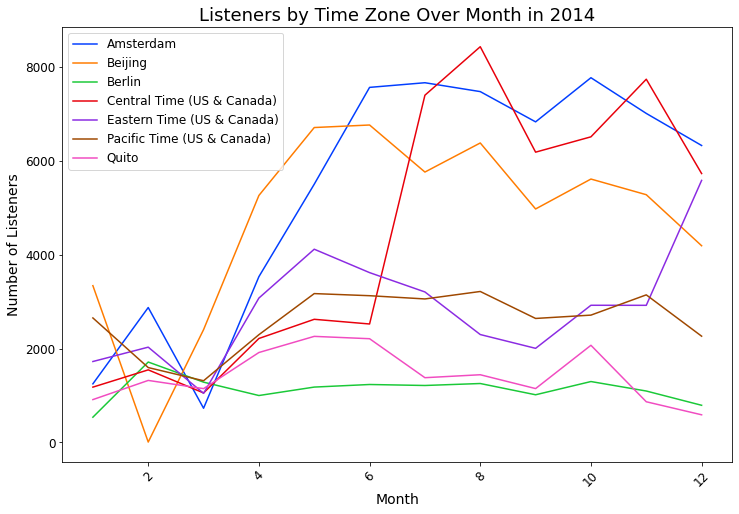

In [12]:
# 1月份-12月份听歌人数的变化

# 获取月份数据并转化成月、地区、数量的dataframe
df['month'] = pd.to_datetime(df['created_at']).dt.month
df['season'] = df['month'] // 4
data_group_by_month = df.groupby(by=['month', 'time_zone']).size().unstack(fill_value=0).stack().reset_index(name='count')
data_group_by_month = data_group_by_month[data_group_by_month['time_zone'].isin(time_zone_view.index)]

# 使用seaborn绘制折线图
sns.lineplot(data=data_group_by_month, x='month', y='count', hue='time_zone', palette='bright')
plt.title('Listeners by Time Zone Over Month in 2014')
plt.ylabel('Number of Listeners')
plt.xlabel('Month')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

In [13]:
df['season'].value_counts()

2    124628
1    115308
0     36012
3     27734
Name: season, dtype: int64

**结论：** 一年中1-3月听歌人数都比较少，4-11月有逐步增加的趋势，11-12月又减少

Text(0.5, 0, 'Frequency')

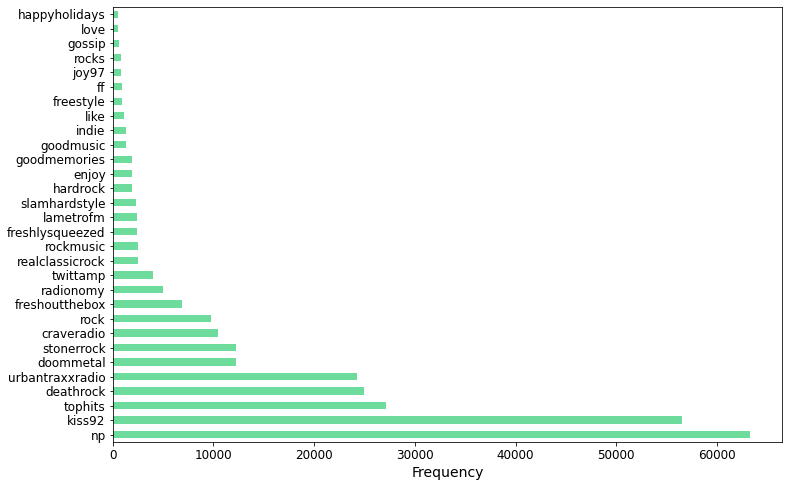

In [14]:
# valence 和 score（歌曲情感和用户使用的标签情绪评分）
hashtags = df['hashtag'].value_counts()
hashtags = hashtags[hashtags > 100][:30]
fig, axes = plt.subplots(1, 1)
hashtags.plot.barh(ax=axes, color='#2ecc71', alpha=0.7) # 翠绿
plt.xlabel('Frequency')

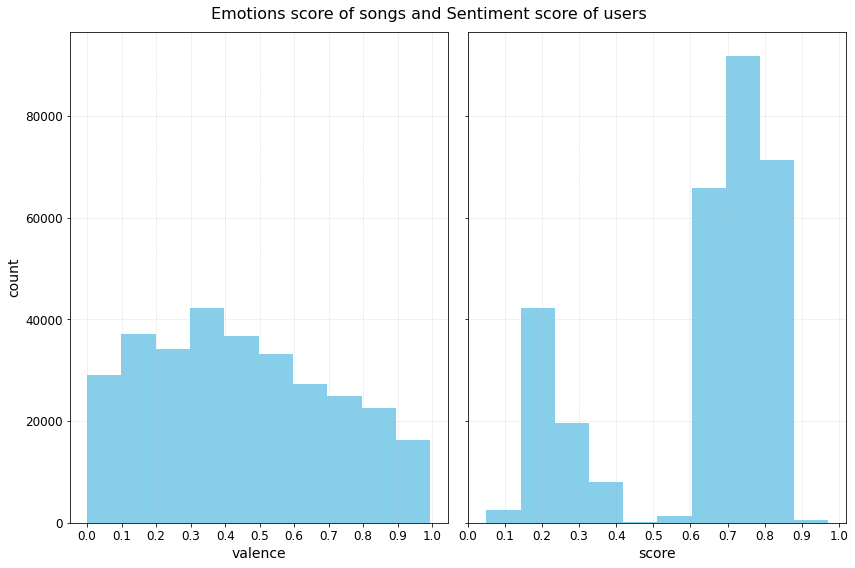

valence:(mean: 0.44598693863976135, std: 0.26114989233134456)
score:(mean: 0.6181650721820705, std: 0.21972775294645072)


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
fig.suptitle("Emotions score of songs and Sentiment score of users", fontsize=16)

# 直方图和KDE曲线
axes[0].hist(df['valence'],color='skyblue')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_xlabel('valence')
axes[0].set_ylabel('count')

axes[1].hist(df['score'],color='skyblue')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlabel('score')

axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()
print(f"valence:(mean: {df['valence'].mean()}, std: {df['valence'].std()})")
print(f"score:(mean: {df['score'].mean()}, std: {df['score'].std()})")

**结论2：** 歌曲的情感几乎呈正态分布，用户情绪得分主要分布在两侧（0-0.4，0.6-1.0）即偏向于negtive或positive，在平静（neutral）时很少听音乐

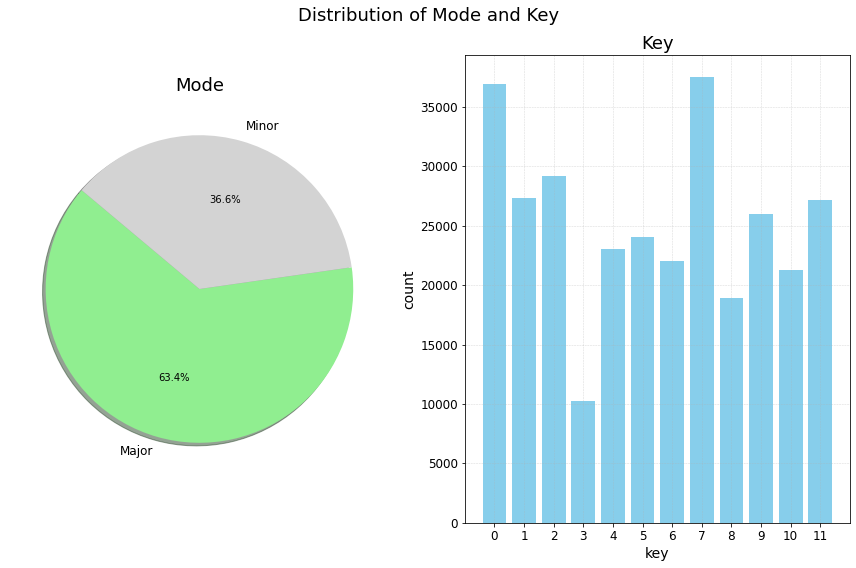

In [16]:
# 调式和音调
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Mode and Key', fontsize=18)

# 条形图
modes = df['mode'].value_counts()
keys = df['key'].value_counts()

axes[0].set_title('Mode')
axes[0].pie(modes.values, labels=['Major', 'Minor'], colors=['lightgreen', 'lightgray'], autopct='%1.1f%%', shadow=True, startangle=140)

axes[1].bar(keys.index, keys.values, color='skyblue')
axes[1].set_title('Key')
axes[1].set_xlabel('key')
axes[1].set_ylabel('count')
axes[1].set_xticks([i for i in range(0, 12)])

axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

0: C
1: C# / Db
2: D
3: D# / Eb
4: E
5: F
6: F# / Gb
7: G
8: G# / Ab
9: A
10: A# / Bb
11: B

**结论3：** 用户收听的音乐以大调歌曲为主，且各调式中，以C、D、E、F、G、A、B居多，升调#降调b相对少

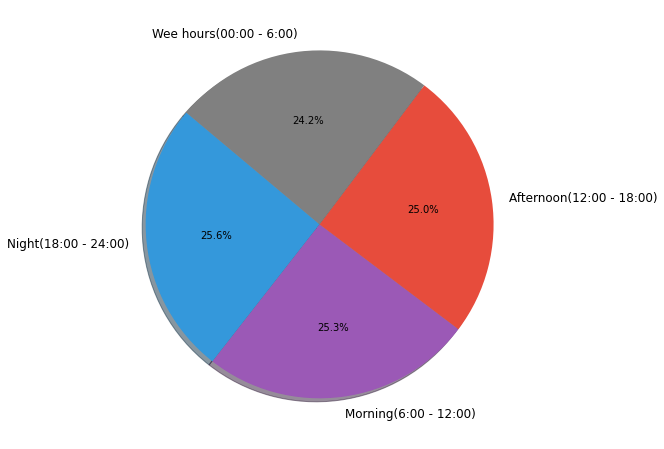

In [17]:
from datetime import datetime

created_time = df['created_at']
created_time = pd.to_datetime(created_time)

# 创建新特征，一周中的星期几
df['weekday_index'] = created_time.dt.weekday

# 创建新特征，是否是周末
df['weekend'] = (df['weekday_index'] >= 5)

# 定义一个函数，根据时间判断属于早、中、晚哪个时段
def classify_time_period(time):
    if time.hour < 6:
        return 'Wee hours(00:00 - 6:00)'
    elif time.hour < 12:
        return 'Morning(6:00 - 12:00)'
    elif time.hour < 18:
        return 'Afternoon(12:00 - 18:00)'
    else:
        return 'Night(18:00 - 24:00)'

# 应用函数，创建一个新列来存储时段分类
period = created_time.apply(lambda x: classify_time_period(x))
df['day_time'] = period

period = period.value_counts()

fig, axes = plt.subplots(1, 1)
axes.pie(period.values, labels=period.index, autopct='%1.1f%%', shadow=True, startangle=140, colors=['#3498db', '#9b59b6', '#e74c3c','gray' ])
ax.set_ylabel('')
plt.show()

**结论4：** 听歌时间主要集中在0-12点（problem: 是哪个时区的时间？）

#### 双变量分析
* valence/score

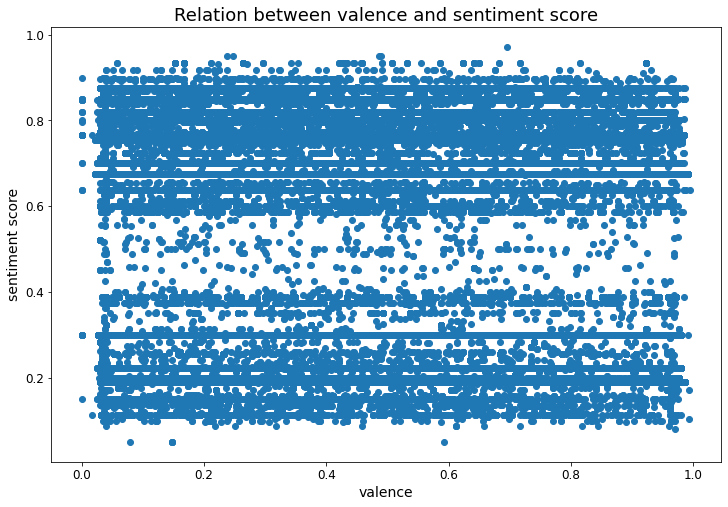

In [18]:
# valence and score
plt.scatter(df['valence'], df['score'])
plt.xlabel('valence')
plt.ylabel('sentiment score')
plt.title('Relation between valence and sentiment score')
plt.show()

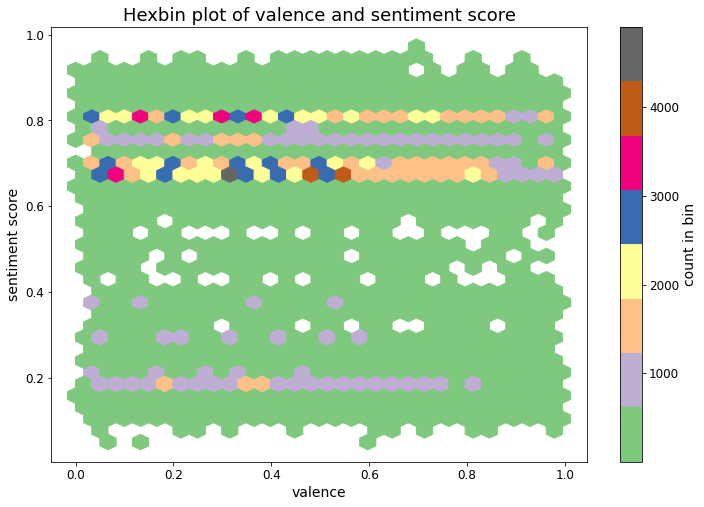

In [19]:
# 使用plt.hexbin来绘制六边形箱图
plt.hexbin(df['valence'], df['score'], gridsize=30, cmap='Accent', mincnt=1)
cb = plt.colorbar(label='count in bin')
plt.xlabel('valence')
plt.ylabel('sentiment score')
plt.title('Hexbin plot of valence and sentiment score')
plt.show()

In [20]:
# # 使用scipy.stats的gaussian_kde进行核密度估计
# from scipy.stats import gaussian_kde

# # 创建一个二维核密度估计
# kde = gaussian_kde([df['valence'], df['score']])

# # 创建一个网格来评估kde
# valence_grid, score_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# kde_values = kde(np.vstack([valence_grid.ravel(), score_grid.ravel()]))

# # 绘制等高线图
# plt.contourf(valence_grid, score_grid, kde_values.reshape(valence_grid.shape), levels=10, cmap='viridis')
# plt.colorbar(label='Density')
# plt.title('Contour plot of valence and score')
# plt.xlabel('Valence')
# plt.ylabel('Score')
# plt.show()

In [21]:
# 计算Pearson相关系数和spearmanr相关系数
from scipy.stats import spearmanr

pearson_correlation_coefficient = np.corrcoef(df['valence'], df['score'])[0, 1]
print(f'pearson相关系数：{pearson_correlation_coefficient}')
# 计算Spearman相关系数
spearman_correlation_coefficient, p_value = spearmanr(df['valence'], df['score'])
print(f'spearman相关系数：{spearman_correlation_coefficient}')

pearson相关系数：-0.0043920767957918525
spearman相关系数：-0.012188220983650326


**Pearson相关系数**：Pearson相关系数衡量的是两个连续变量之间的线性关系的强度和方向。

**Spearman相关系数**：Spearman相关系数衡量的是两个变量之间的单调关系的强度。

**结论5：** valence和sentiment score存在很弱的正相关性

#### 多变量分析

* 散点图矩阵分析（score与、Instrumentalness、livenes、speechiness等内容特征之间的关系）

In [22]:
df.describe()

,user_id,score,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hours,month,season,weekday_index
count,3.036820e+05,303682.000000,303682.0,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000,303682.000000
mean,7.432104e+08,0.618165,1.0,0.570280,0.623769,5.336612,-8.915302,0.633709,0.100953,0.322850,0.231588,0.210791,0.445987,122.040473,11.636314,7.359498,1.474457,2.987467
std,6.540217e+08,0.219728,0.0,0.179191,0.266659,3.593820,5.445871,0.481791,0.161074,0.350111,0.357393,0.190825,0.261150,29.593791,6.916936,3.077755,0.818028,2.016468
min,2.129130e+05,0.050000,1.0,0.000000,0.000756,0.000000,-41.808000,0.000000,0.000000,0.000000,0.000000,0.011200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.684025e+08,0.637500,1.0,0.454000,0.430000,2.000000,-11.000000,0.000000,0.036100,0.009550,0.000000,0.096800,0.224000,100.511000,6.000000,5.000000,1.000000,1.000000
50%,4.937799e+08,0.700000,1.0,0.581000,0.675000,6.000000,-7.564000,1.000000,0.049500,0.157000,0.000462,0.125000,0.423000,122.567000,12.000000,8.000000,2.000000,3.000000
75%,1.083272e+09,0.766667,1.0,0.708000,0.853000,8.000000,-5.254000,1.000000,0.084000,0.648000,0.514000,0.260000,0.655000,139.288000,18.000000,10.000000,2.000000,5.000000
max,2.933948e+09,0.971875,1.0,0.981000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,0.995000,0.995000,0.995000,243.372000,23.000000,12.000000,3.000000,6.000000


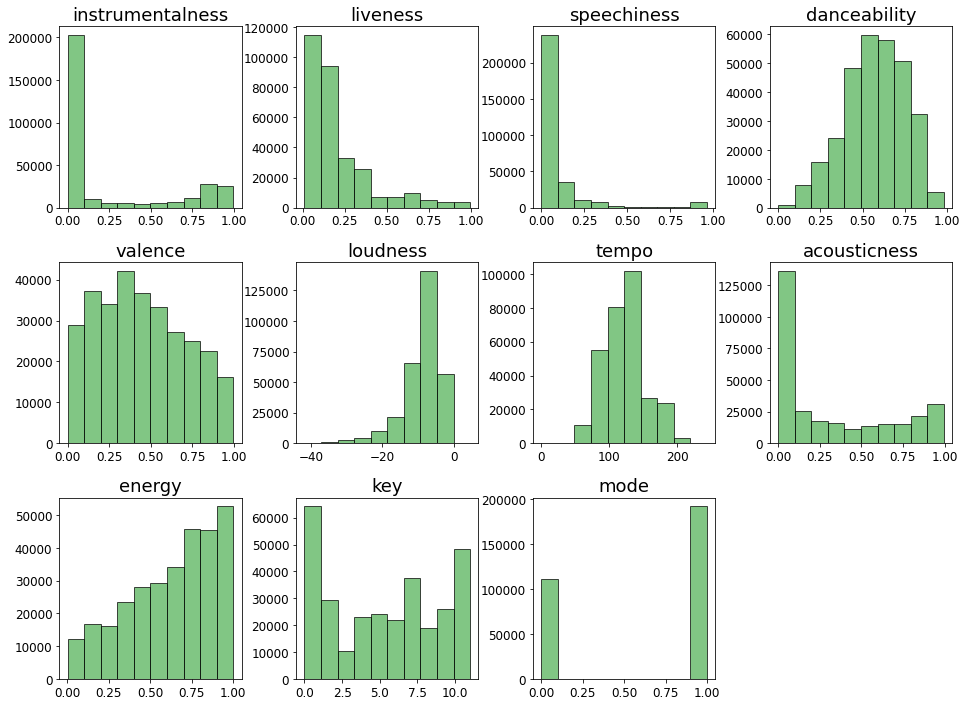

In [23]:
import matplotlib.pyplot as plt
# 对音频内容特征绘制直方图查看分布
columns = ['instrumentalness', 'liveness', 'speechiness', 
           'danceability', 'valence', 'loudness', 'tempo', 
           'acousticness', 'energy', 'key', 'mode']
df.hist(column=columns, bins=10, grid=False, figsize=(16, 12), color='#4CAF50', edgecolor='black', alpha=0.7, layout=(3, 4))

# 显示图形
plt.show()

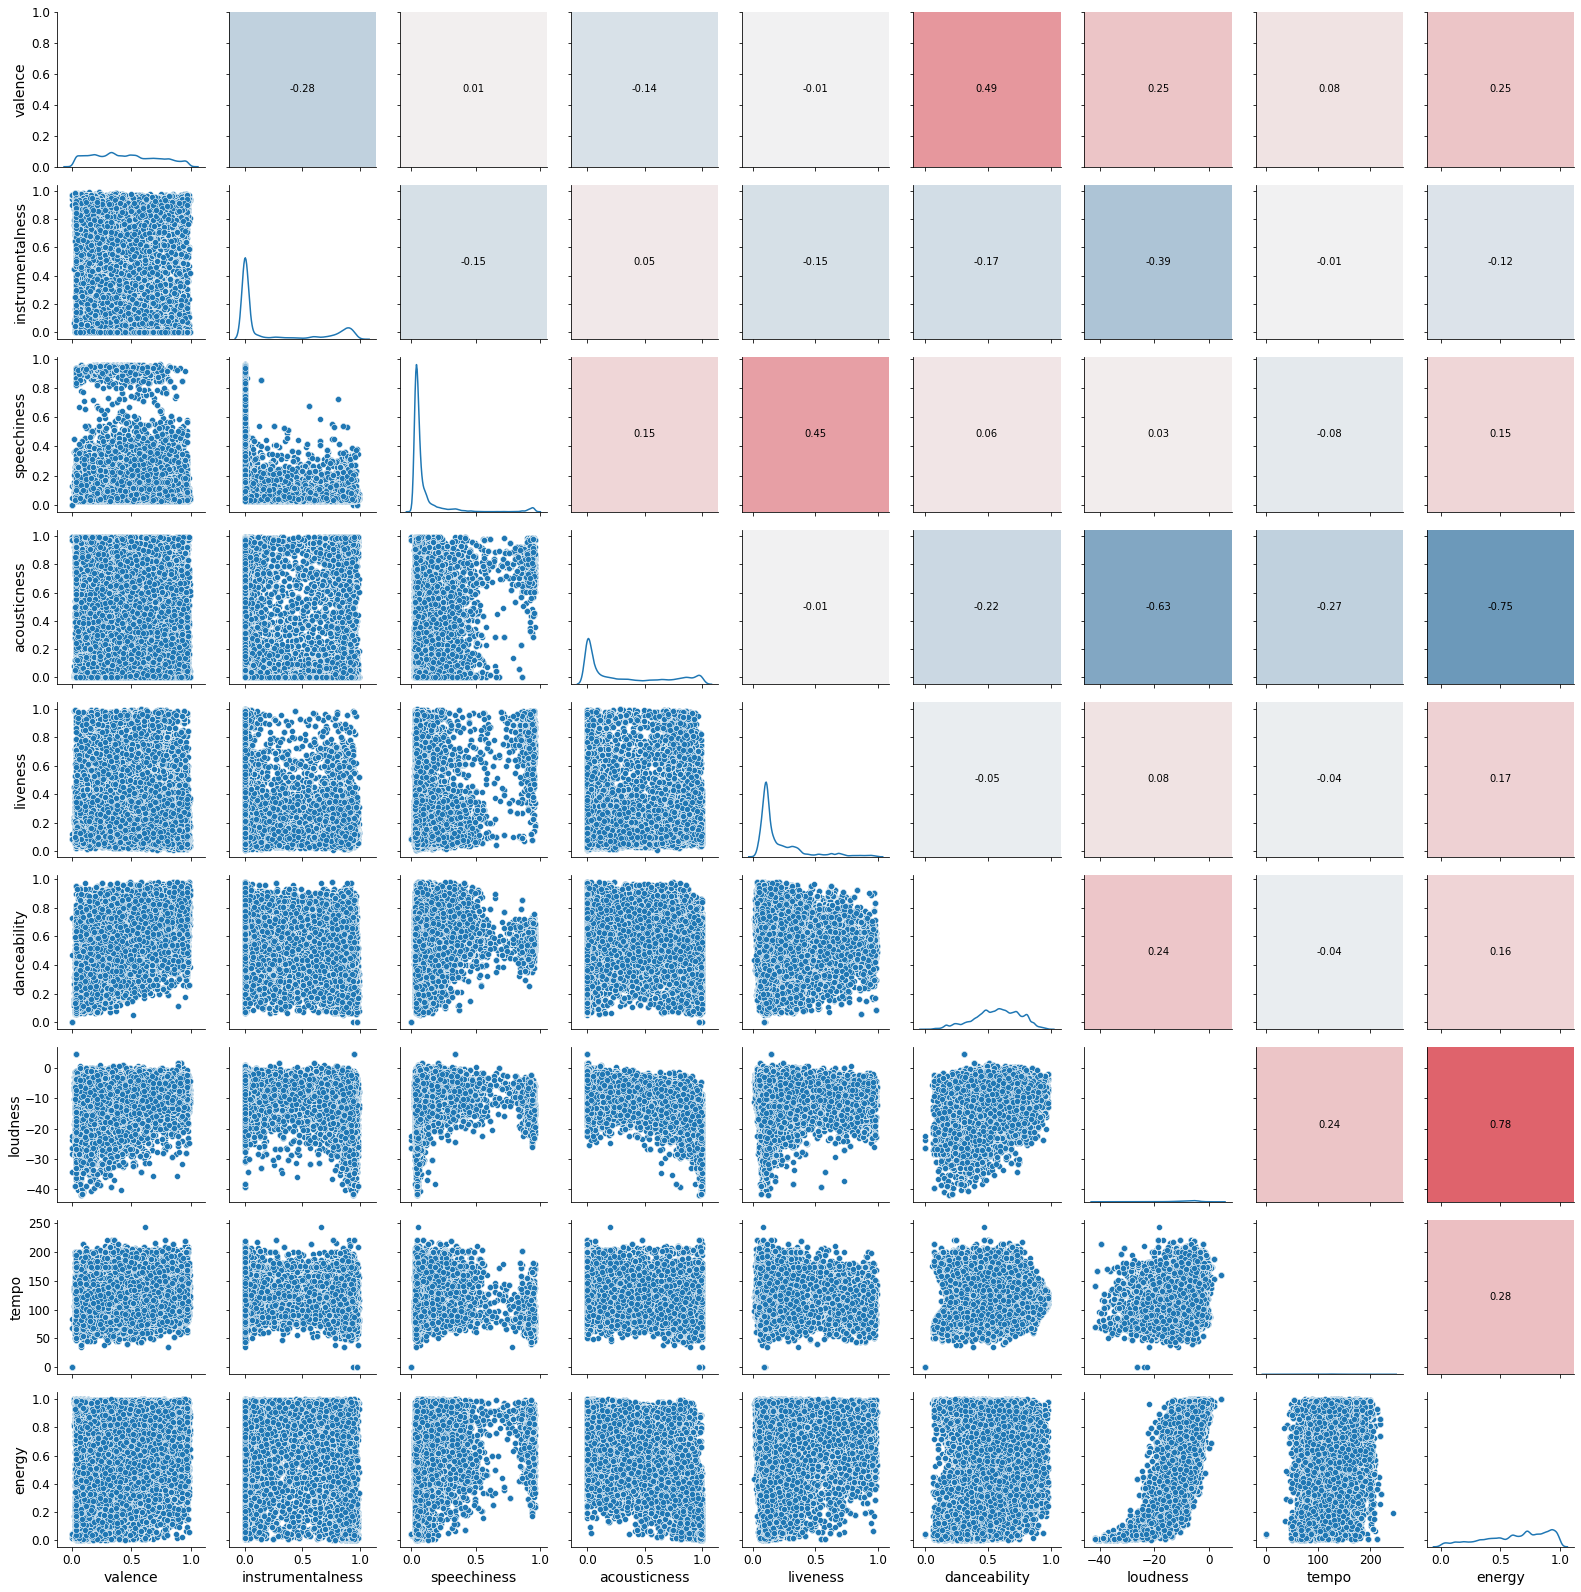

In [24]:
import seaborn as sns
from scipy import stats
from matplotlib.patches import Circle

# 进行相关性分析的列
columns = ['valence', 'instrumentalness', 'speechiness', 'acousticness', 
           'liveness', 'danceability', 'loudness', 'tempo', 'energy']

# 初始化PairGrid
g = sns.PairGrid(df[columns])

# 对角线上绘制核密度分布，反映其分布特性
g.map_diag(sns.kdeplot)

# 下三角绘制散点图
g.map_lower(sns.scatterplot)

# 上三角显示相关系数
def corrfunc(x, y, **kwargs):
    r, _ = stats.pearsonr(x, y)
    facecolor = sns.diverging_palette(240, 10, n=9, as_cmap=True)(0.5*(r+1))
    ax = plt.gca()
    ax.add_patch(plt.Circle((0.5, 0.5), transform=ax.transAxes, facecolor=facecolor, edgecolor='none'))
    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes, ha='center', va='center')

    
g.map_upper(corrfunc)

plt.show()

**结论6：** 各特征之间没有太强的相关性，其中vocal与情绪得分score、vocal与rhythm有弱的正相关，reality和rhythm有稍强的负相关。其他的特征诸如key、mode、rhythm、reality都与情绪分数score没有太大关联

### 回归分析
我们最关心的输入，应该是score，表征用户情绪，最关心的输出，应是valence，表征歌曲的情感倾向。这样就可以根据用户的情绪输入，来推荐一些相关的歌曲。但是这就导致其他音频特征liveness、tempo、energy等无法作为输入？因为我们没法在用户输入时直接获取到这些特征。能不能对每一个特征都和valence做一个回归看看呢？

In [25]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.metrics import mean_squared_error

# X = df['score'].values.reshape(-1, 1)
# y = df['valence'].values.reshape(-1, 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# models = [RandomForestRegressor(n_estimators=100, random_state=42), 
#           LinearRegression(),
#           Ridge(alpha=1.0),
#           Lasso(alpha=1.0)
#          ]

# for model in models:
#     model = model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     Rscore = model.score(X_test, y_test)
#     print(f'{model.__class__.__name__}: mse:{mse}, Rscore:{Rscore}')

**结论：** 几个回归模型的均方差和Rscore显示回归模型的效果并不好，Rscore接近0甚至负表示和直接预测valence为平均值差别不大甚至不如直接预测平均值

根据MSE和Rscore分数，可以看出这些回归模型在当前的任务上表现都不是很理想。尽管随机森林回归器在预测准确性上略胜一筹，但所有模型在解释目标变量的变异性上都做得不好。
这可能意味着：
数据之间的关系可能并不是线性的，或者存在复杂的非线性模式，这对于线性模型来说是个挑战。

特征和目标之间可能存在噪声或其他未观测到的变量影响，导致模型难以捕捉到它们之间的关系。

模型的复杂度可能不足以捕捉数据中存在的模式，或者数据不足以训练更复杂的模型。

### 聚类分析
先根据音频特征将音乐聚为N类，再试图联合score、语言、时间、地点做一个上下文的推荐呢？结果如何

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# 转成int型
df['mode'] = df['mode'].astype(int)
df['key'] = df['key'].astype(int)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303682 entries, 0 to 361345
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           303682 non-null  int64  
 1   track_id          303682 non-null  object 
 2   hashtag           303682 non-null  object 
 3   created_at        303682 non-null  object 
 4   score             303682 non-null  float64
 5   lang              303682 non-null  object 
 6   tweet_lang        303682 non-null  object 
 7   time_zone         303682 non-null  object 
 8   rating            303682 non-null  int64  
 9   danceability      303682 non-null  float64
 10  energy            303682 non-null  float64
 11  key               303682 non-null  int64  
 12  loudness          303682 non-null  float64
 13  mode              303682 non-null  int64  
 14  speechiness       303682 non-null  float64
 15  acousticness      303682 non-null  float64
 16  instrumentalness  30

In [28]:
# 获得聚类数据
# 聚类使用
cluster_columns = ['instrumentalness', 'liveness', 'valence', 'tempo', 'acousticness', 'energy',
                   'mode', 'key', 'track_id']
df_cluster =  df[cluster_columns]
df_cluster.info()

df_cluster.to_csv('./data/cluster_data.csv', index = False)

# 分类及回归使用
classify_columns = ['score', 'hashtag', 'lang', 'tweet_lang', 'time_zone' ,
                     'month', 'hours','track_id']
# 衍生列
add_columns = ['season', 'day_time', 'weekday_index', 'weekend']
classify_columns += add_columns

df_classify = df[classify_columns]
df_classify.to_csv('./data/classify_data.csv', index = False)
print(df_classify.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303682 entries, 0 to 361345
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   instrumentalness  303682 non-null  float64
 1   liveness          303682 non-null  float64
 2   valence           303682 non-null  float64
 3   tempo             303682 non-null  float64
 4   acousticness      303682 non-null  float64
 5   energy            303682 non-null  float64
 6   mode              303682 non-null  int64  
 7   key               303682 non-null  int64  
 8   track_id          303682 non-null  object 
dtypes: float64(6), int64(2), object(1)
memory usage: 31.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 303682 entries, 0 to 361345
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          303682 non-null  float64
 1   hashtag        303682 non-null  object 
 2   lan